In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models

In [5]:
IMG_SIZE = 128

def load_data(image_path, mask_path):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_path))

    for file in image_files:
        img = cv2.imread(os.path.join(image_path, file))
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img / 255.0

        mask = cv2.imread(os.path.join(mask_path, file), 0)
        mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
        mask = mask / 255.0

        # Convert to binary mask
        mask = (mask > 0.5).astype(np.float32)
        mask = np.expand_dims(mask, axis=-1)

        images.append(img)
        masks.append(mask)

    return np.array(images), np.array(masks)

X, y = load_data("dataset/images", "dataset/masks")

print("Images shape:", X.shape)
print("Masks shape:", y.shape)

Images shape: (2, 128, 128, 3)
Masks shape: (2, 128, 128, 1)


In [6]:
def build_unet():

    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 3))

    # Encoder
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    c1 = layers.Conv2D(32, 3, activation='relu', padding='same')(c1)
    p1 = layers.MaxPooling2D()(c1)

    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(p1)
    c2 = layers.Conv2D(64, 3, activation='relu', padding='same')(c2)
    p2 = layers.MaxPooling2D()(c2)

    # Bottleneck
    b1 = layers.Conv2D(128, 3, activation='relu', padding='same')(p2)

    # Decoder
    u1 = layers.UpSampling2D()(b1)
    u1 = layers.concatenate([u1, c2])
    c3 = layers.Conv2D(64, 3, activation='relu', padding='same')(u1)

    u2 = layers.UpSampling2D()(c3)
    u2 = layers.concatenate([u2, c1])
    c4 = layers.Conv2D(32, 3, activation='relu', padding='same')(u2)

    outputs = layers.Conv2D(1, 1, activation='sigmoid')(c4)

    model = models.Model(inputs, outputs)
    return model

model = build_unet()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 128, 128,  │        896 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │      9,248 │ conv2d_8[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 64, 64,    │     18,496 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │     36,928 │ conv2d_10[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_11[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 32, 32,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_2     │ (None, 64, 64,    │          0 │ conv2d_12[0][0]   │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 64, 64,    │          0 │ up_sampling2d_2[… │
│ (Concatenate)       │ 192)              │            │ conv2d_11[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 64, 64,    │    110,656 │ concatenate_2[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_3     │ (None, 128, 128,  │          0 │ conv2d_13[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 128, 128,  │          0 │ up_sampling2d_3[… │
│ (Concatenate)       │ 96)               │            │ conv2d_9[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 128, 128,  │     27,680 │ concatenate_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 128, 128,  │         33 │ conv2d_14[0][0]   │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 277,793 (1.06 MB)

 Trainable params: 277,793 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
history = model.fit(
    X,
    y,
    epochs=15,
    batch_size=1,
    validation_split=0.5
)

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.6946 - loss: 0.6776 - val_accuracy: 0.5792 - val_loss: 0.6735
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6951 - loss: 0.6342 - val_accuracy: 0.5792 - val_loss: 0.6688
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.6951 - loss: 0.6017 - val_accuracy: 0.5792 - val_loss: 0.6892
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.6951 - loss: 0.6253 - val_accuracy: 0.5792 - val_loss: 0.6667
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6951 - loss: 0.5966 - val_accuracy: 0.5792 - val_loss: 0.6699
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.6951 - loss: 0.6103 - val_accuracy: 0.5792 - val_loss: 0.6692
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.6951 - loss: 0.6046 - val_accuracy: 0.5792 - val_loss: 0.6674
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.6951 - loss: 0.5923 - val_accuracy: 0.5792 - val_loss: 0.

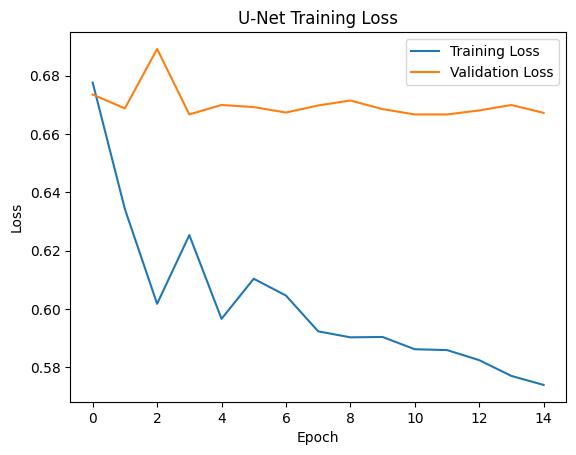

In [8]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("U-Net Training Loss")
plt.legend()
plt.show()

In [16]:
index = 0

pred = model.predict(np.expand_dims(X[index], axis=0))[0]

# Use higher threshold to avoid 100% flood
threshold = 0.7
binary_mask = (pred > threshold).astype(np.uint8)

# Calculate flood coverage
flood_pixels = np.count_nonzero(binary_mask)
total_pixels = binary_mask.size

flood_ratio = flood_pixels / total_pixels

print("Flood Coverage:", round(flood_ratio * 100, 2), "%")

# Depth estimation (assume max depth = 2 meters)
MAX_DEPTH = 2
estimated_depth = flood_ratio * MAX_DEPTH

print("Estimated Flood Depth:", round(estimated_depth, 2), "meters")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Flood Coverage: 50.63 %
Estimated Flood Depth: 1.01 meters


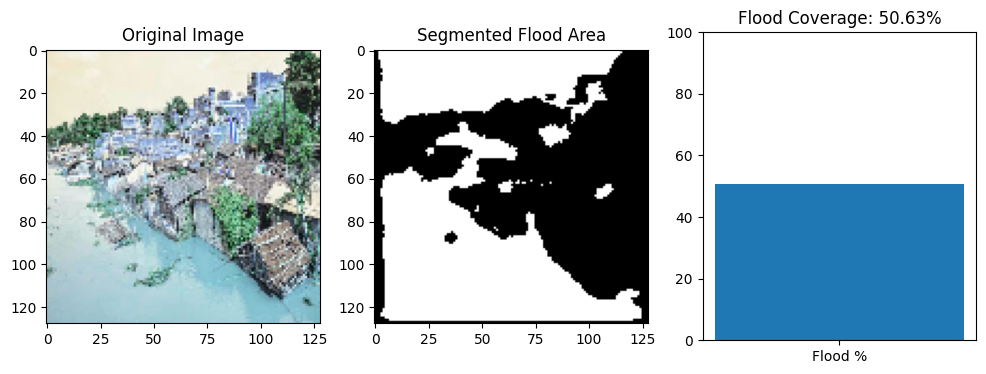

In [18]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
plt.imshow(X[index])
plt.title("Original Image")

plt.subplot(1,3,2)
plt.imshow(binary_mask.squeeze(), cmap='gray')
plt.title("Segmented Flood Area")

plt.subplot(1,3,3)
plt.bar(["Flood %"], [flood_ratio * 100])
plt.ylim(0,100)
plt.title(f"Flood Coverage: {flood_ratio * 100:.2f}%")

plt.show()